## Brain Tumor Classification - Image Segmentation

Ayesha Aziz
<br> DS5500 - Capstone: Applications in Data Science
<br> Phase 1 Project

**Import Data Libraries**

In [1]:
!rm -r Brain-Tumor-Classification
!git clone https://github.com/azizayesha/Brain-Tumor-Classification.git
!pip install tensorflow_addons

Cloning into 'Brain-Tumor-Classification'...
remote: Enumerating objects: 3072, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 3072 (delta 3), reused 4 (delta 0), pack-reused 3044
Receiving objects: 100% (3072/3072), 81.60 MiB | 32.05 MiB/s, done.
Resolving deltas: 100% (6/6), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd
from pandas.core.indexes.base import Index
import numpy as np
import os
import random

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, Activation,Concatenate, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import  plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
import tensorflow_addons as tfa
from keras.applications.vgg19 import VGG19
from albumentations import (Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, 
HorizontalFlip, Rotate)

import cv2
import seaborn as sb
from PIL import Image
from operator import index

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import fbeta_score

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

### Helper Functions

1. *Load Dataset*

In [3]:
def load_dataset(file_path):
    """
    Load images from all tumor sub-folders from training/test folders
    :param file_path: path to the training/test folder
    :return:
        image_data: numpy array with scan_image RGB pixel data
        image_labels: numpy array with class labels for images
    """
    image_data = []
    image_classes = []

    # go over each tumor sub-folder
    for tumor_type in os.listdir(file_path):
        # read each scan_image file within the folder
        for img_file in os.listdir(os.path.join(file_path, tumor_type)):
            image_path = os.path.join(file_path, tumor_type, img_file)

            # convert BGR format to RGB
            scan_image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)

            # resize images to the same size, set by IMAGE_DIM
            scan_image = cv2.resize(scan_image, (IMAGE_DIM, IMAGE_DIM), interpolation=INTERPOLATION_)

            # convert image data into a numpy array of float32 data type
            scan_image = np.array(scan_image)
            scan_image = scan_image.astype('float32')

            # normalize the pixel values between 0-1
            scan_image /= 255

            # add pixel information to image data list
            image_data.append(scan_image)

            # add image label to the label list
            image_classes.append(tumor_type)

    return np.array(image_data), np.array(image_classes)

2. *Plot MRI scans*

In [4]:
def plot_image(file_path):
    """
    Plot 5 random MRI scans from a given folder
    :param file_path: path to the folder
    :return: subplots of scans
    """
    plt.figure(figsize=(20, 5))
    for i in range(5):
        file = random.choice(os.listdir(file_path))
        img_path = os.path.join(file_path, file)
        img = mpimg.imread(img_path)
        ax = plt.subplot(1, 5, i + 1)
        title = os.path.basename(os.path.normpath(file_path))
        ax.title.set_text(title)
        plt.imshow(img)
    plt.show()


3. *One-Hot-Encoding of labels*

In [5]:
def one_hot_encoding(class_names, y_data, binary=False):
    """
    convert y-label data into numerical encoding
    :type binary: bool
    :param class_names: class (tumor) names
    :param y_data: y_label data
    :param binary: if true, the encoding would be 0/1, if false, it would result in multiclass encoding
    :return: one-hot-encoded y-labels
    """
    # if binary classification has to be performed
    if binary:
        # convert multiclass labels to tumor/no_tumor
        class_names = list(set(['tumor' if label != "no_tumor" else label for label in class_names]))
        # change y labels from multiclass to binary tumor/no_tumor
        y_data = ['tumor' if label != "no_tumor" else label for label in y_data]

    # ensuring that 'no_tumor' is at index 0, to assist in indexing later on, as we want it to correspond to label 0
    if class_names[0] != 'no_tumor':
        no_tumor = class_names.index('no_tumor')
        # swap elements in the list so the element at index 0 is no_tumor
        class_names[0], class_names[no_tumor] = class_names[no_tumor], class_names[0]

    # replace image labels with respective class index
    indexed_y_data = []
    for img in y_data:
        indexed_y_data.append(class_names.index(img))
    
    if binary:
        return np.array(indexed_y_data)
    
    else:
        y_data = to_categorical(indexed_y_data)
        return np.array(y_data)

4. F1 Score calculation

Taken from https://neptune.ai/blog/implementing-the-macro-f1-score-in-keras

In [6]:
def f1_score(y_pred, y_true):
    def recall_score(y_pred, y_true):
        # True Positives
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (positives + K.epsilon())    
        return recall 
    
    
    def precision_score(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        pred_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (pred_positives + K.epsilon())
        return precision 
    
    precision, recall = precision_score(y_pred, y_true), recall_score(y_pred, y_true)
    
    F1 = 2 * ((precision * recall)/(precision + recall + K.epsilon()))
    return F1


5. Plot F1 score and Log Loss of a model while training

In [7]:
def plot_f1_loss(model, accuracy=False):
    """
    Plot the Training and Validation F1-score and Loss over epochs of a given model
    :param model: given model
    :param accuracy: boolean for whether to plot accuracy or not
    :return:
        time series plots
    """
    f1 = model.history['f1_score']
    val_f1 = model.history['val_f1_score']
    loss = model.history['loss']
    val_loss = model.history['val_loss']

    epochs = range(1, len(f1) + 1)

    plt.plot(epochs, f1, 'm', label='Training F1 Score')
    plt.plot(epochs, val_f1, 'c', label='Validation F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'm', label='Training Loss')
    plt.plot(epochs, val_loss, 'c', label='Validation Loss')
    plt.title('Training and validation Cross Entropy Loss')
    plt.legend()

    if accuracy:
        acc = model.history['accuracy']
        val_acc = model.history['val_accuracy']
        plt.figure()
        plt.plot(epochs, acc, 'm', label='Training Accuracy')
        plt.plot(epochs, val_acc, 'c', label='Validation Accuracy')
        plt.title('Training and validation Accuracy')
        plt.legend()

    plt.show()

#### Load Training and Test Data

In [10]:
# Hyperparameters - Binary Classification

IMG_ROTATION = 30
FLIP_IMG = True
IMG_ZOOM = 0.1
IMG_HEIGHT_SHIFT = 0.1
IMG_WIDTH_SHIFT = 0.1
BRIGHTNESS=[0.3,1.5]
IMAGE_DIM = 224
INTERPOLATION_ = cv2.INTER_AREA
VALIDATION_SIZE = 0.1
CLASSES = 2

RANDOM_SEED = 0
BATCH_SIZE = 64
EPOCHS = 10
LOSS = 'binary_crossentropy'
MONITOR_METRIC = ["val_f1_score", "val_accuracy"]
F1_SCORE = tfa.metrics.F1Score(average='macro', num_classes=CLASSES)

In [11]:
# load Training and Test data

project_folder = "/content/Brain-Tumor-Classification/data/"
X_train, y_train = load_dataset(project_folder + 'Training')
X_test, y_test = load_dataset(project_folder + 'Testing')

# create a list of class names
labels = set(y_train)
labels = list(labels)

#### Exploratory Data Analysis

In [ ]:
print('Size of training data:', len(X_train))
print('Size of test data:', len(X_test))
print('Training data shape:', X_train.shape)
print('Class names in the dataset:')
print(labels)

Size of training data: 2870
Size of test data: 394
Training data shape: (2870, 224, 224, 3)
Class names in the dataset:
['meningioma_tumor', 'pituitary_tumor', 'glioma_tumor', 'no_tumor']


#### Plot the counts of labels in Test and Train data, and display MRI scans

In [ ]:
# plot tumor counts
sb.countplot(data=pd.DataFrame(y_train, columns=['labels']), x = 'labels', palette="light:#5A9").set(title='Training labels')
plt.show()
sb.countplot(data=pd.DataFrame(y_test, columns=['labels']), x = 'labels', palette="light:#5A9").set(title='Test labels')
plt.show()

In [ ]:
# Plot 5 random MRI scans for tumor/no tumor data
plot_image(project_folder + 'Testing/glioma_tumor')
plot_image(project_folder +'Testing/pituitary_tumor')
plot_image(project_folder + 'Testing/meningioma_tumor')
plot_image(project_folder + 'Testing/no_tumor')

Shuffle, one-hot-encode and split the dataset for both binary and multiclass classification


In [12]:
# shuffle training data
X_train, y_train = shuffle(X_train, y_train, random_state=RANDOM_SEED)

# convert y_train and y_test into one-hot-encoded data for binary classification
binary_y_train = one_hot_encoding(labels, y_train, binary=True)
binary_y_test = one_hot_encoding(labels, y_test, binary=True)

# convert y_train and y_test into one-hot-encoded data for multiclass classification
multi_y_train = one_hot_encoding(labels, y_train, binary=False)
multi_y_test = one_hot_encoding(labels, y_test, binary=False)

# split training data into training and validation - binary 
binary_X_train, binary_X_val, binary_y_train, binary_y_val = train_test_split(X_train, binary_y_train, test_size=VALIDATION_SIZE, random_state=RANDOM_SEED)

# split training data into training and validation - multi 
multi_X_train, multi_X_val, multi_y_train, multi_y_val = train_test_split(X_train, multi_y_train, test_size=VALIDATION_SIZE, random_state=RANDOM_SEED)

In [ ]:
binary_X_train.shape, binary_X_val.shape,  binary_y_test.shape, binary_y_train.shape

((2583, 224, 224, 3), (287, 224, 224, 3), (394,), (2583,), (287,), (394,))

In [ ]:
multi_X_train.shape, multi_X_val.shape, X_test.shape, multi_y_test.shape

((2583, 224, 224, 3), (287, 224, 224, 3), (394, 224, 224, 3), (394, 4))

## Binary Classification 

*   Tumor/No Tumor Segmentation

#### Data Augmentation

In [13]:
data_augmentation = ImageDataGenerator(
    # randomly rotate images in the range 0-180
    rotation_range=IMG_ROTATION,
    # randomly enlarge images
    zoom_range=IMG_ZOOM,
    # randomly shift images horizontally
    width_shift_range=IMG_WIDTH_SHIFT,
    # randomly shift images vertically
    height_shift_range=IMG_HEIGHT_SHIFT,
    # randomly flip images vertically
    vertical_flip=FLIP_IMG,
    # brightness range
    brightness_range=BRIGHTNESS)


In [14]:
# Augment training and validation dataset

train_augmented = data_augmentation.flow(binary_X_train, binary_y_train, seed=RANDOM_SEED)
val_augmented = data_augmentation.flow(binary_X_val, binary_y_val, seed=RANDOM_SEED)

Plot Image Augmentation results on a sample image from the dataset

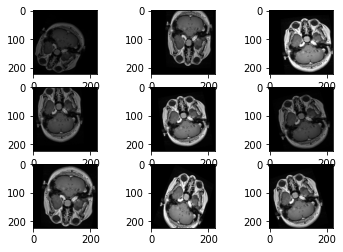

In [ ]:
# take a sample image from the dataset and perform image augmentation on it

sample = X_train[1]
sample = np.expand_dims(sample, 0)

sample_aug = data_augmentation.flow(sample, batch_size=1)

# generate 12 samples and plot
for i in range(9):

	plt.subplot(330 + 1 + i)
	# generate images
	batch = sample_aug.next()
	# convert to unsigned integers for plotting
	image = batch[0].astype('uint8')
	# plot the augmented images
	plt.imshow(image)

plt.show()

Checkpoints during training of models

In [19]:
def callbacks_(model_name, MONITOR_METRIC):

    # stop if no improvements made after 3 epochs (patience) and save the best model
    early_stopping = EarlyStopping(patience=3, restore_best_weights=True)

    # for possible visualization
    tensorboard = TensorBoard(log_dir='logs')

    # save the best model
    checkpoint = ModelCheckpoint(model_name + ".h5", monitor=MONITOR_METRIC, save_best_only=False, mode="max", verbose=1)

    # change the learning rate if no increase/decrease is seen in the model metrics
    reduce_lr = ReduceLROnPlateau(monitor = MONITOR_METRIC, factor = 0.3, patience = 3, min_delta = 0.001, mode='max',verbose=1)

    return early_stopping, tensorboard, checkpoint, reduce_lr

#### Model 1: CNN with Multiple Hidden Layers 

Specifications:

    - No data augmentation
    - Sample size: Full training set, 287 validation samples, 
    - Loss function: Binary cross-entropy
    - Evaluation Metric: Accuracy/F1 Score
    - Optimizer: Adam
    - Epochs: 10
    - Batch Size: 64

In [20]:
cnn_model1 = Sequential()

# input layer
cnn_model1.add(Conv2D(64, kernel_size=(3, 3), padding='same',input_shape=(IMAGE_DIM, IMAGE_DIM, 3))) 
cnn_model1.add(Activation('relu'))
cnn_model1.add(BatchNormalization())

# first layer
cnn_model1.add(Conv2D(64, (3, 3))) 
cnn_model1.add(Activation('relu'))
cnn_model1.add(MaxPooling2D(pool_size=(2, 2))) 
cnn_model1.add(BatchNormalization())
cnn_model1.add(Dropout(0.35))

# third layer
cnn_model1.add(Conv2D(64, (3, 3), padding='same'))
cnn_model1.add(Activation('relu'))
cnn_model1.add(BatchNormalization()) 

# fourth layer
cnn_model1.add(Conv2D(64, (3, 3)))
cnn_model1.add(Activation('relu'))
cnn_model1.add(MaxPooling2D(pool_size=(2, 2))) 
cnn_model1.add(BatchNormalization())
cnn_model1.add(Dropout(0.35)) 

# fifth layer
cnn_model1.add(Conv2D(64, (3, 3), padding='same')) 
cnn_model1.add(Activation('relu'))
cnn_model1.add(BatchNormalization())

cnn_model1.add(Flatten()) 
cnn_model1.add(Dropout(0.5)) 
cnn_model1.add(Dense(128, activation='relu')) 
cnn_model1.add(BatchNormalization())
cnn_model1.add(Dense(1, activation= 'sigmoid')) 

#cnn_model1.summary()

In [ ]:
plot_model(
    cnn_model1,
    to_file="cnn1.png",
    show_shapes=True,
    show_layer_names=True
)

In [21]:
cnn_model1.compile(optimizer='adam',
             loss= tf.losses.BinaryFocalCrossentropy() ,
             metrics=[f1_score,'accuracy'])

In [ ]:
model1 = cnn_model1.fit(binary_X_train, binary_y_train, 
                         verbose=1, 
                         validation_data=(binary_X_val, binary_y_val),
                         epochs=EPOCHS,
                         callbacks=[callbacks_('model1', MONITOR_METRIC)],
                         batch_size=BATCH_SIZE)

In [ ]:
cnn_model1.save('cnn1_model1.h5')

loss1, accuracy1 = cnn_model1.evaluate(X_test, y_test)
print('Test loss and accuracy: ', loss1, accuracy1)

In [ ]:
pred = cnn_model1.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test, axis=1)
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.94      0.39      0.56       289
           1       0.36      0.93      0.52       105

    accuracy                           0.54       394
   macro avg       0.65      0.66      0.54       394
weighted avg       0.79      0.54      0.55       394



Plot out the model metrics for training/validation data against epochs

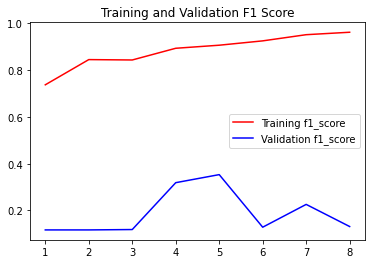

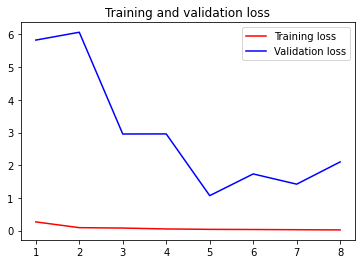

In [ ]:
f1 = model1.history['f1_score']
val_f1 = model1.history['val_f1_score']
loss = model1.history['loss']
val_loss = model1.history['val_loss']

epochs = range(1, len(f1) + 1)

plt.plot(epochs, f1, 'r', label='Training f1_score')
plt.plot(epochs, val_f1, 'b', label='Validation f1_score')
plt.title('Training and Validation F1 Score')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

#### Model 2: CNN with Four Layers

Specifications:

    - Data augmentation 
    - Binary cross-entropy used as the loss function
    - Accuracy used as the metric
    - batch size: 35
    - Optimizer: Adam

In [ ]:
model2 = cnn_model1.fit_generator(train_augmented,
                            epochs=EPOCHS,
                            steps_per_epoch=X_train.shape[0]//BATCH_SIZE,
                            validation_data=val_augmented,
                            validation_steps=X_val.shape[0]//BATCH_SIZE,
                            callbacks=[early_stopping, checkpoint, tensorboard, reduce_lr])



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 0.2102 - f1_score: 0.5905 
Epoch 1: val_f1_score improved from -inf to 0.26586, saving model to cnn_layer1.h5
40/40 [==============================] - 618s 15s/step - loss: 0.2102 - f1_score: 0.5905 - val_loss: 9.6413 - val_f1_score: 0.2659 - lr: 0.0010
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 0.1307 - f1_score: 0.6081 
Epoch 2: val_f1_score improved from 0.26586 to 0.46922, saving model to cnn_layer1.h5
40/40 [==============================] - 623s 16s/step - loss: 0.1307 - f1_score: 0.6081 - val_loss: 0.6992 - val_f1_score: 0.4692 - lr: 0.0010
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 0.1047 - f1_score: 0.6629 
Epoch 3: val_f1_score improved from 0.46922 to 0.52817, saving model to cnn_layer1.h5
40/40 [==============================] - 617s 15s/step - loss: 0.1047 - f1_score: 0.6629 - val_loss: 0.2917 - val_f1_score: 0.5282 - lr: 0.0010
Epoch 4/10
40/40 [==========

In [ ]:
cnn_model1.save('cnn1_model2.h5')

loss2, f1_model2 = cnn_model1.evaluate(X_test, y_test)
print('Test loss and F1 score: ', loss2, f1_model2)

13/13 [==============================] - 40s 3s/step - loss: 0.1679 - f1_score: 0.4231
Test loss and accuracy:  0.16788385808467865 0.4231332242488861


In [ ]:
# get predictions from the test set

pred = cnn_model1.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test, axis=1)
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.73      1.00      0.85       289
           1       0.00      0.00      0.00       105

    accuracy                           0.73       394
   macro avg       0.37      0.50      0.42       394
weighted avg       0.54      0.73      0.62       394



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


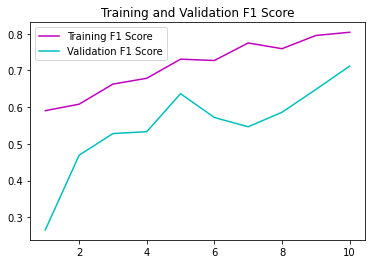

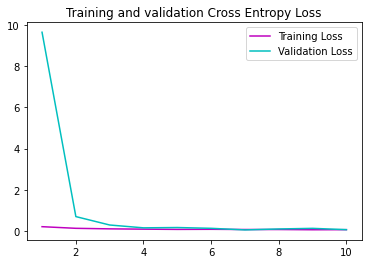

In [ ]:
# plot the model's f1-scores and loss
plot_f1_loss(model2)

###Model 3: CNN with VGG19

In [ ]:
vgg19_ = VGG19(weights='imagenet', input_shape=(IMAGE_DIM,IMAGE_DIM,3), include_top=False) 

vgg19_model = Sequential()
vgg19_model.add(vgg19_)
vgg19_model.add(Flatten())
vgg19_model.add(BatchNormalization())
vgg19_model.add(Dense(256, kernel_initializer='he_uniform'))
vgg19_model.add(BatchNormalization())
vgg19_model.add(Activation('relu'))
vgg19_model.add(Dropout(0.3))
vgg19_model.add(Dense(2, activation='softmax'))

# not training the model layers again
for layer in vgg19_model.layers:
    layer.trainable = False

    
vgg19_model.compile(
    loss=LOSS,
    optimizer='adam',
    metrics=['accuracy' , 'AUC', F1_SCORE]
)

vgg19_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_5 (Flatten)         (None, 25088)             0         
                                                                 
 batch_normalization_14 (Bat  (None, 25088)            100352    
 chNormalization)                                                
                                                                 
 dense_10 (Dense)            (None, 256)               6422784   
                                                                 
 batch_normalization_15 (Bat  (None, 256)              1024      
 chNormalization)                                                
                                                                 
 activation_9 (Activation)   (None, 256)              

In [ ]:
early_stopping, tensorboard, checkpoint, reduce_lr = callbacks("vgg19", MONITOR_METRIC)

model3 = vgg19_model.fit_generator(train_augmented,
                            epochs=EPOCHS,
                            steps_per_epoch=X_train.shape[0]//BATCH_SIZE,
                            validation_data=val_augmented,
                            validation_steps=X_val.shape[0]//BATCH_SIZE,
                            callbacks=[early_stopping, checkpoint, tensorboard, reduce_lr])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/10
40/40 [==============================] - ETA: 0s - loss: 1.9417 - accuracy: 0.6516 - auc: 0.6944 - f1_score: 0.5072 
Epoch 1: val_f1_score improved from -inf to 0.54148, saving model to vgg19.h5
40/40 [==============================] - 816s 20s/step - loss: 1.9417 - accuracy: 0.6516 - auc: 0.6944 - f1_score: 0.5072 - val_loss: 1.4999 - val_accuracy: 0.7031 - val_auc: 0.7283 - val_f1_score: 0.5415 - lr: 0.0010
Epoch 2/10
40/40 [==============================] - ETA: 0s - loss: 1.9724 - accuracy: 0.6507 - auc: 0.6929 - f1_score: 0.5088 
Epoch 2: val_f1_score improved from 0.54148 to 0.58033, saving model to vgg19.h5
40/40 [==============================] - 806s 20s/step - loss: 1.9724 - accuracy: 0.6507 - auc: 0.6929 - f1_score: 0.5088 - val_loss: 1.3528 - val_accuracy: 0.6953 - val_auc: 0.7563 - val_f1_score: 0.5803 - lr: 0.0010
Epoch 3/10
40/40 [==============================] - ETA: 0s - loss: 1.9088 - accuracy: 0.6869 - auc: 0.7215 - f1_score: 0.5256 
Epoch 3: val_f1_score

In [ ]:
# get predictions from the test set

pred = vgg19_model.predict(X_test)
pred = np.argmax(pred,axis=1)
y_test_new = np.argmax(y_test, axis=1)
print(classification_report(y_test_new,pred))

              precision    recall  f1-score   support

           0       0.23      0.75      0.36       105
           1       0.53      0.10      0.17       289

    accuracy                           0.27       394
   macro avg       0.38      0.43      0.26       394
weighted avg       0.45      0.27      0.22       394



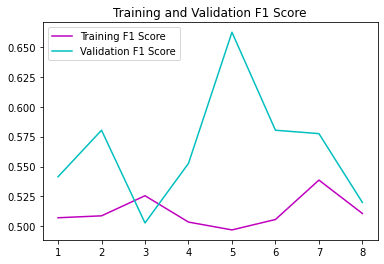

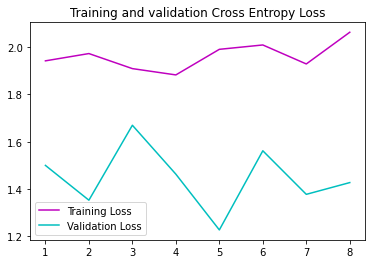

In [ ]:
# plot the f1 score and loss
plot_f1_loss(model3)

## Multiclass Classification 

*   Pituitary
*   Glioma
*   Meningioma
*   No tumor





In [ ]:
# y label encoding 

